#  Plant Disease Dataset Preparation

This notebook prepares raw image data for training, validation, and testing.  
Steps:
1. Define configuration and directories  
2. Analyze class distribution  
3. Preprocess images  
4. Split dataset (train/val/test)  
5. Organize data into folders  
6. Create image generators (with augmentation)  


In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import json

## 1. Configuration

In [12]:
BASE_DIR = 'data'
RAW_DIR = os.path.join(BASE_DIR, 'raw')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed')
AUGMENTED_DIR = os.path.join(BASE_DIR, 'augmented')

IMG_SIZE = (224, 224)
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
BATCH_SIZE = 32

# Ensure directory structure
for root in [PROCESSED_DIR, AUGMENTED_DIR]:
    os.makedirs(root, exist_ok=True)
    for sub in ['train', 'val', 'test']:
        os.makedirs(os.path.join(root, sub), exist_ok=True)

print("Directory structure initialized.")

Directory structure initialized.


## 2. Class Distribution

Bacteria: 569 images
Early_blight: 1000 images
Fungi: 748 images
Healthy: 353 images
Late_blight: 1000 images
Nematode: 68 images
Pest: 611 images
Phytopthora: 347 images
Virus: 532 images


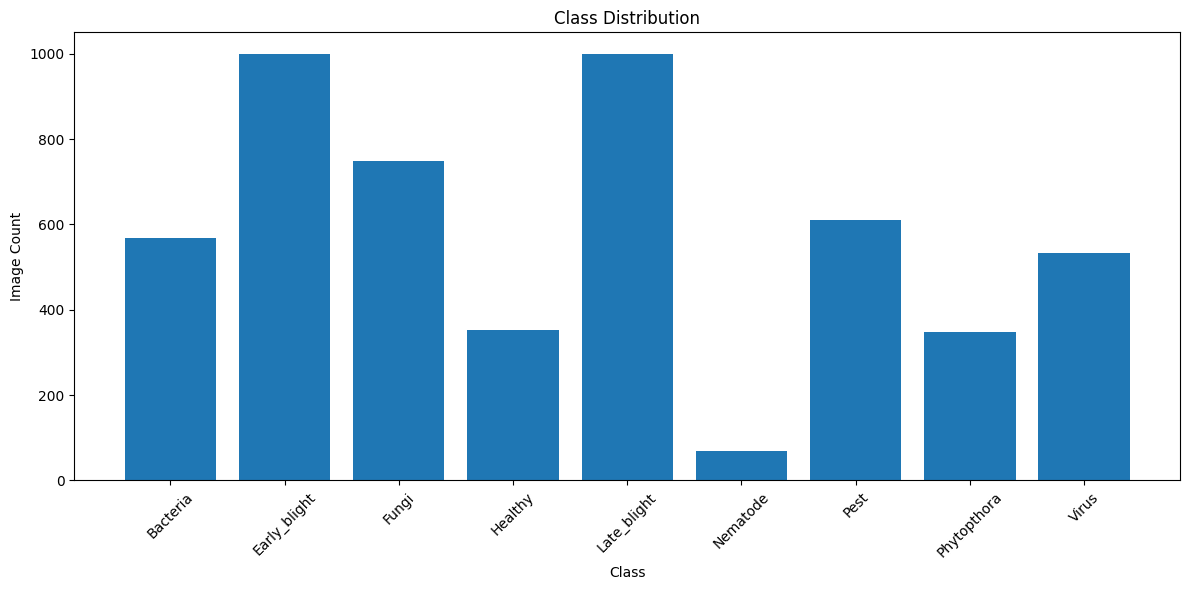

In [13]:
classes = sorted([d for d in os.listdir(RAW_DIR) if os.path.isdir(os.path.join(RAW_DIR, d))])
class_distribution = {}

for class_name in classes:
    class_path = os.path.join(RAW_DIR, class_name)
    num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    class_distribution[class_name] = num_images
    print(f"{class_name}: {num_images} images")

# Plot distribution
plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DIR, 'class_distribution.png'))
plt.show()


## 3. Metadata and Preprocessing

In [14]:
# Create dataframe with metadata
data = []
for class_name in classes:
    for img_file in os.listdir(os.path.join(RAW_DIR, class_name)):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            data.append({
                'image_path': os.path.join(RAW_DIR, class_name, img_file),
                'class': class_name,
                'file_name': img_file
            })

df = pd.DataFrame(data)
print(f"DataFrame created with {len(df)} entries.")
df.head()


DataFrame created with 5228 entries.


,image_path,class,file_name
0,data\raw\Bacteria\1692332350433.jpg,Bacteria,1692332350433.jpg
1,data\raw\Bacteria\1692332350457.jpg,Bacteria,1692332350457.jpg
2,data\raw\Bacteria\1692333303178.jpg,Bacteria,1692333303178.jpg
3,data\raw\Bacteria\1692333631862.jpg,Bacteria,1692333631862.jpg
4,data\raw\Bacteria\1692333631989.jpg,Bacteria,1692333631989.jpg


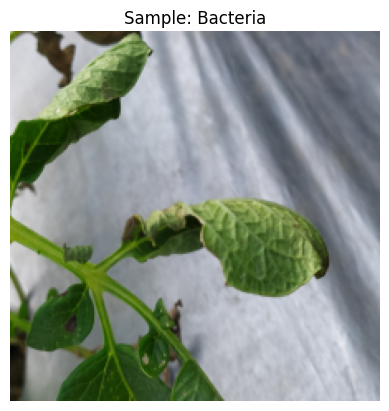

In [15]:
# Basic preprocessing: load, resize, convert RGB
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    return img

# Preview sample
sample_img = preprocess_image(df.iloc[0]['image_path'])
plt.imshow(sample_img)
plt.title(f"Sample: {df.iloc[0]['class']}")
plt.axis('off')
plt.show()


## 4. Train / Validation / Test Split

In [16]:
train_val_df, test_df = train_test_split(
    df, test_size=TEST_SIZE, stratify=df['class'], random_state=RANDOM_STATE
)

train_df, val_df = train_test_split(
    train_val_df, test_size=VAL_SIZE/(1-TEST_SIZE),
    stratify=train_val_df['class'], random_state=RANDOM_STATE
)

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

train_df.to_csv(os.path.join(PROCESSED_DIR, 'train_metadata.csv'), index=False)
val_df.to_csv(os.path.join(PROCESSED_DIR, 'val_metadata.csv'), index=False)
test_df.to_csv(os.path.join(PROCESSED_DIR, 'test_metadata.csv'), index=False)


Train: 3658
Validation: 785
Test: 785


## 5. Organize Images

In [18]:
def organize_images(df, subset):
    for _, row in df.iterrows():
        class_dir = os.path.join(PROCESSED_DIR, subset, row['class'])
        os.makedirs(class_dir, exist_ok=True)
        dest_path = os.path.join(class_dir, row['file_name'])
        if not os.path.exists(dest_path):
            shutil.copy(row['image_path'], dest_path)

for subset, data_split in [('train', train_df), ('val', val_df), ('test', test_df)]:
    organize_images(data_split, subset)

print("Images organized by class into train/val/test folders.")


Images organized by class into train/val/test folders.


## 6. Data Generators (with Augmentation)


In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.02,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, 'train'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, 'val'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(PROCESSED_DIR, 'test'),
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

with open(os.path.join(PROCESSED_DIR, 'class_indices.json'), 'w') as f:
    json.dump(train_generator.class_indices, f)

print("Generators created.")


Found 3658 images belonging to 9 classes.
Found 785 images belonging to 9 classes.
Found 785 images belonging to 9 classes.
Generators created.


## 7. Generator Sanity Check


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


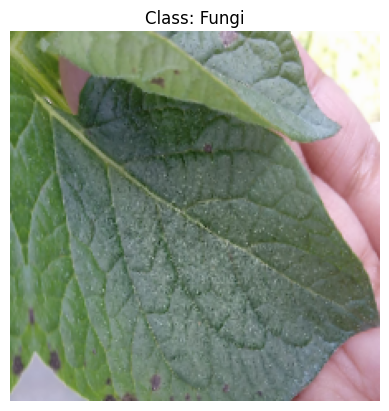

In [20]:
images, labels = next(train_generator)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

plt.imshow(images[0].astype('uint8'))
class_idx = np.argmax(labels[0])
class_name = list(train_generator.class_indices.keys())[class_idx]
plt.title(f"Class: {class_name}")
plt.axis('off')
plt.show()
